In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix
import math
import seaborn as sn
from scipy.stats import pearsonr

In [4]:
df = pd.read_csv("BTP Data-001/BTP Data/Process_Rainfall_Data/7Palakkad-Alathur_processed.csv")

In [5]:
df

,Date,RF
0,1976-01-01,0.0
1,1976-01-02,0.0
2,1976-01-03,0.0
3,1976-01-04,0.0
4,1976-01-05,0.0
...,...,...
13144,2011-12-27,0.0
13145,2011-12-28,0.0
13146,2011-12-29,0.0
13147,2011-12-30,0.0


In [6]:
df = df.replace(-1.0,np.nan)

In [7]:
df

,Date,RF
0,1976-01-01,0.0
1,1976-01-02,0.0
2,1976-01-03,0.0
3,1976-01-04,0.0
4,1976-01-05,0.0
...,...,...
13144,2011-12-27,0.0
13145,2011-12-28,0.0
13146,2011-12-29,0.0
13147,2011-12-30,0.0


In [8]:
df = df.assign(RF=df.RF.interpolate(method='linear',limit_direction='both'))

In [9]:
df

,Date,RF
0,1976-01-01,0.0
1,1976-01-02,0.0
2,1976-01-03,0.0
3,1976-01-04,0.0
4,1976-01-05,0.0
...,...,...
13144,2011-12-27,0.0
13145,2011-12-28,0.0
13146,2011-12-29,0.0
13147,2011-12-30,0.0


In [10]:
df.isna().sum()

Date    0
RF      0
dtype: int64

In [11]:
tot_RF = []
latency = 7
dt = []
week = []
for i in range(0,len(df)-latency,latency):
    tot_RF.append(np.sum(df['RF'][i:i+latency]))
    dd = str(df['Date'][i])+ "~" + str(df['Date'][i+latency])
    dt.append(dd)

In [12]:
len(dt)

1878

In [13]:
data = tot_RF
U = [min(data) , max(data)]

In [14]:
DATA = (data-U[0])/(U[1] - U[0])
Data = (np.array(DATA))
Data = np.reshape(Data , (Data.shape[0],1))

slt1 = int(0.80*len(data))
slt2 = int(0.90*len(data))
Train = Data[:slt1]
Val = Data[slt1:slt2]
Test = Data[slt1:]
DT = dt[slt1:]

In [15]:
x_axis = [i+1 for i in range(len(data))]
x_tr = x_axis[:slt1]
x_val = x_axis[slt1:slt2]
x_tst = x_axis[slt2:]
al = (U[1] - U[0]) + U[0]

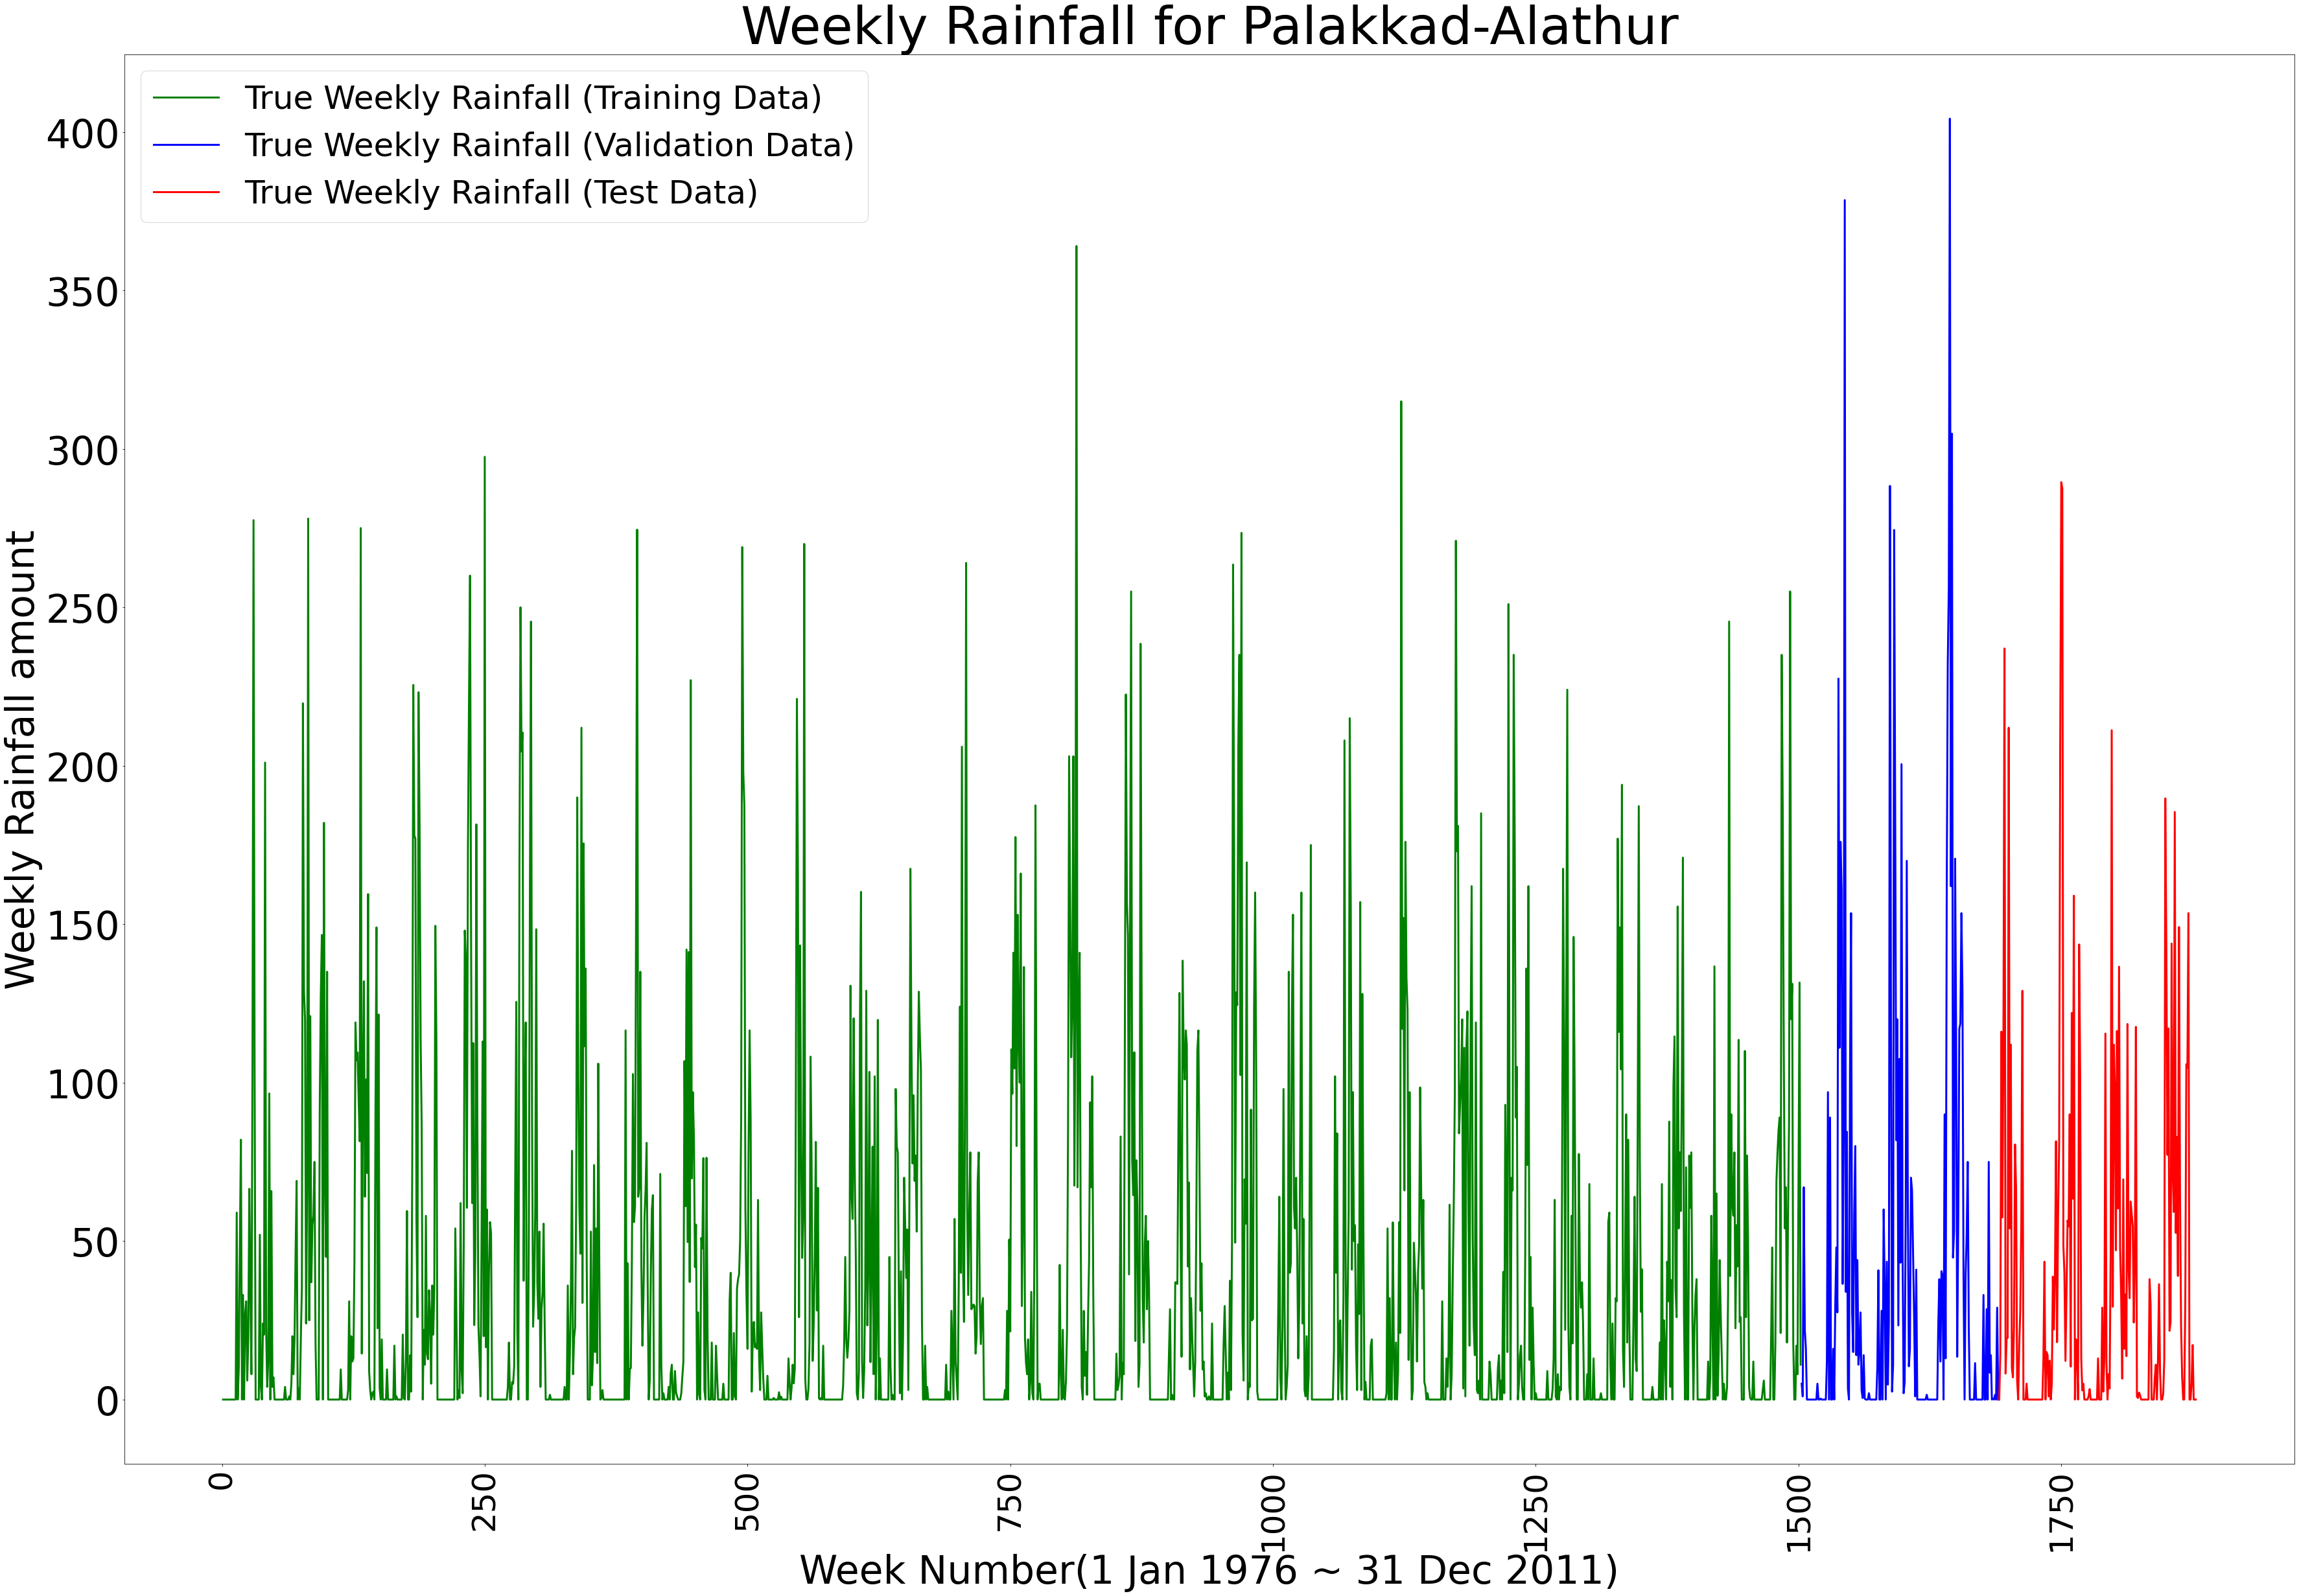

In [17]:
f = plt.figure() 
f.set_figwidth(60) 
f.set_figheight(40)
plt.title('Weekly Rainfall for Palakkad-Alathur', fontsize = 80)
plt.xticks(fontsize=50, rotation=90)
plt.yticks(fontsize=60, rotation=0)
#plt.xticks(ticks,xaxis)
plt.ylabel('Weekly Rainfall amount',fontsize=60)
plt.xlabel('Week Number(1 Jan 1976 ~ 31 Dec 2011)',fontsize=60)
plt.plot(x_tr, Train*al, 'g',linestyle='-', linewidth='3', label = 'True Weekly Rainfall (Training Data)')
plt.plot(x_val, Val*al, 'b',linestyle='-', linewidth='3', label = 'True Weekly Rainfall (Validation Data)')
plt.plot(x_tst, Data[slt2:]*al, 'r',linestyle='-', linewidth='3', label = 'True Weekly Rainfall (Test Data)')
plt.legend(loc='best',prop={'size': 50})

In [18]:
len(DT)

376

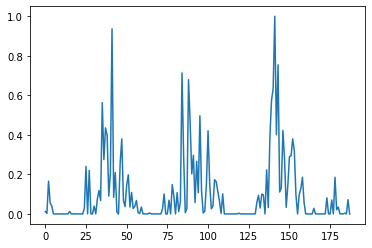

In [19]:
plt.plot(Val)

In [26]:
import GMM_K

numStates = 5
numMixtureComp = 2
dimension = 1
numIterations = 200
threshold = 0.0
covariance_type = 'full'
verbose = True


model = GMM_K.GmmHmmLikelihoodSimilarity_K(
    numStates=numStates,
    numMixtureComp=numMixtureComp,
    dimension=dimension,
    numIterations=numIterations,
    threshold=threshold,
    covariance_type=covariance_type,
    verbose = True
)

In [27]:
logValues = model.train([Train])

         1         259.0262             +nan
         2        1330.3851       +1071.3589
         3        1647.5218        +317.1367
         4        1950.0879        +302.5661
         5        2239.0839        +288.9959
         6        2494.0103        +254.9264
         7        2763.6557        +269.6455
         8        3117.5465        +353.8908
         9        3505.2947        +387.7481
        10        3974.3365        +469.0419
        11        4547.5740        +573.2375
        12        5529.7552        +982.1812
        13        7606.6835       +2076.9283
        14       95285.2865      +87678.6030
        15        4494.3477      -90790.9387


Has model converged:  True


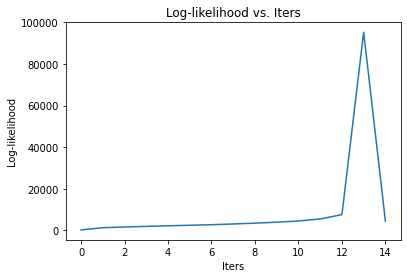

In [28]:
plt.plot(logValues, label='log-likelihood')
plt.xlabel('Iters')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood vs. Iters')
print('Has model converged: ', model.model.monitor_.converged)

In [71]:
K = len(Train)
rmse = []
MAE = []
CC = []
for k in range(1,K):
    pred = model.predict(Val,k)
    p2 = pred*(U[1] - U[0]) + U[0]
    T1 = Val*(U[1] - U[0]) + U[0]
    rmse.append(mean_squared_error(p2, T1, squared=False))
    MAE.append(mae(T1,p2))
    d1 = np.array(T1)
    d1 = np.reshape(d1 , d1.shape[0])
    d2 = np.array(p2)
    d2 = np.reshape(d2 , d2.shape[0])
    corr, _ = pearsonr(d1, d2)
    CC.append(corr)
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (50,10))
# ax1.set_xlim(1, K)
# ax1.set_xlabel('K', fontweight ='bold', fontsize = 30)
# ax1.set_ylabel('RMSE', fontweight ='bold', fontsize = 30)
# ax1.grid(True)
# ax1.set_title('RMSE vs K', fontsize = 30, fontweight ='bold')
# ax1.plot(rmse, linewidth='5')
# ax1.tick_params(axis='both', which='major', labelsize=30)


# ax2.set_xlim(1, K)
# ax2.set_xlabel('K', fontweight ='bold', fontsize = 30)
# ax2.set_ylabel('MAE', fontweight ='bold', fontsize = 30)
# ax2.grid(True)
# ax2.set_title('MAE vs K', fontsize = 30, fontweight ='bold')
# ax2.plot(MAE, linewidth='5')
# ax2.tick_params(axis='both', which='major', labelsize=30)

# ax3.set_xlim(1, K)
# ax3.set_xlabel('K', fontweight ='bold', fontsize = 30)
# ax3.set_ylabel('CC', fontweight ='bold', fontsize = 30)
# ax3.grid(True)
# ax3.set_title('CC vs K', fontsize = 30, fontweight ='bold')
# ax3.plot(CC, linewidth='5')
# ax3.tick_params(axis='both', which='major', labelsize=30)


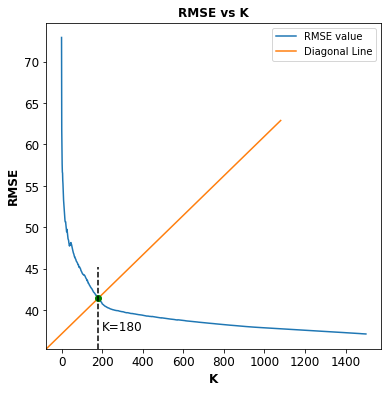

In [76]:
th = 180
st = 'K='+str(th)
f, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('K', fontweight ='bold', fontsize = 12)
ax.set_ylabel('RMSE', fontweight ='bold', fontsize = 12)
ax.set_title('RMSE vs K', fontsize = 12, fontweight ='bold')
ax.plot(rmse, '-' , label = 'RMSE value')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.plot([0, 0.7], [0, 0.7], transform=ax.transAxes, label = 'Diagonal Line')
ax.plot(th, rmse[th-1], 'go')
ax.axvline(x=th , ymax = 0.25,ls='--',c='black')
ax.text(th+20, rmse[th-1]-4, st, fontsize=12)
ax.legend()

In [29]:
pred = model.predict(Test,len(Train))
p2 = pred*(U[1] - U[0]) + U[0]
T1 = Test*(U[1] - U[0]) + U[0]

In [30]:
len(DT)

376

In [31]:
xaxis = [DT[i] for i in range(0,len(DT),10)]
ticks = [i+1 for i in range(0,len(DT),10)]

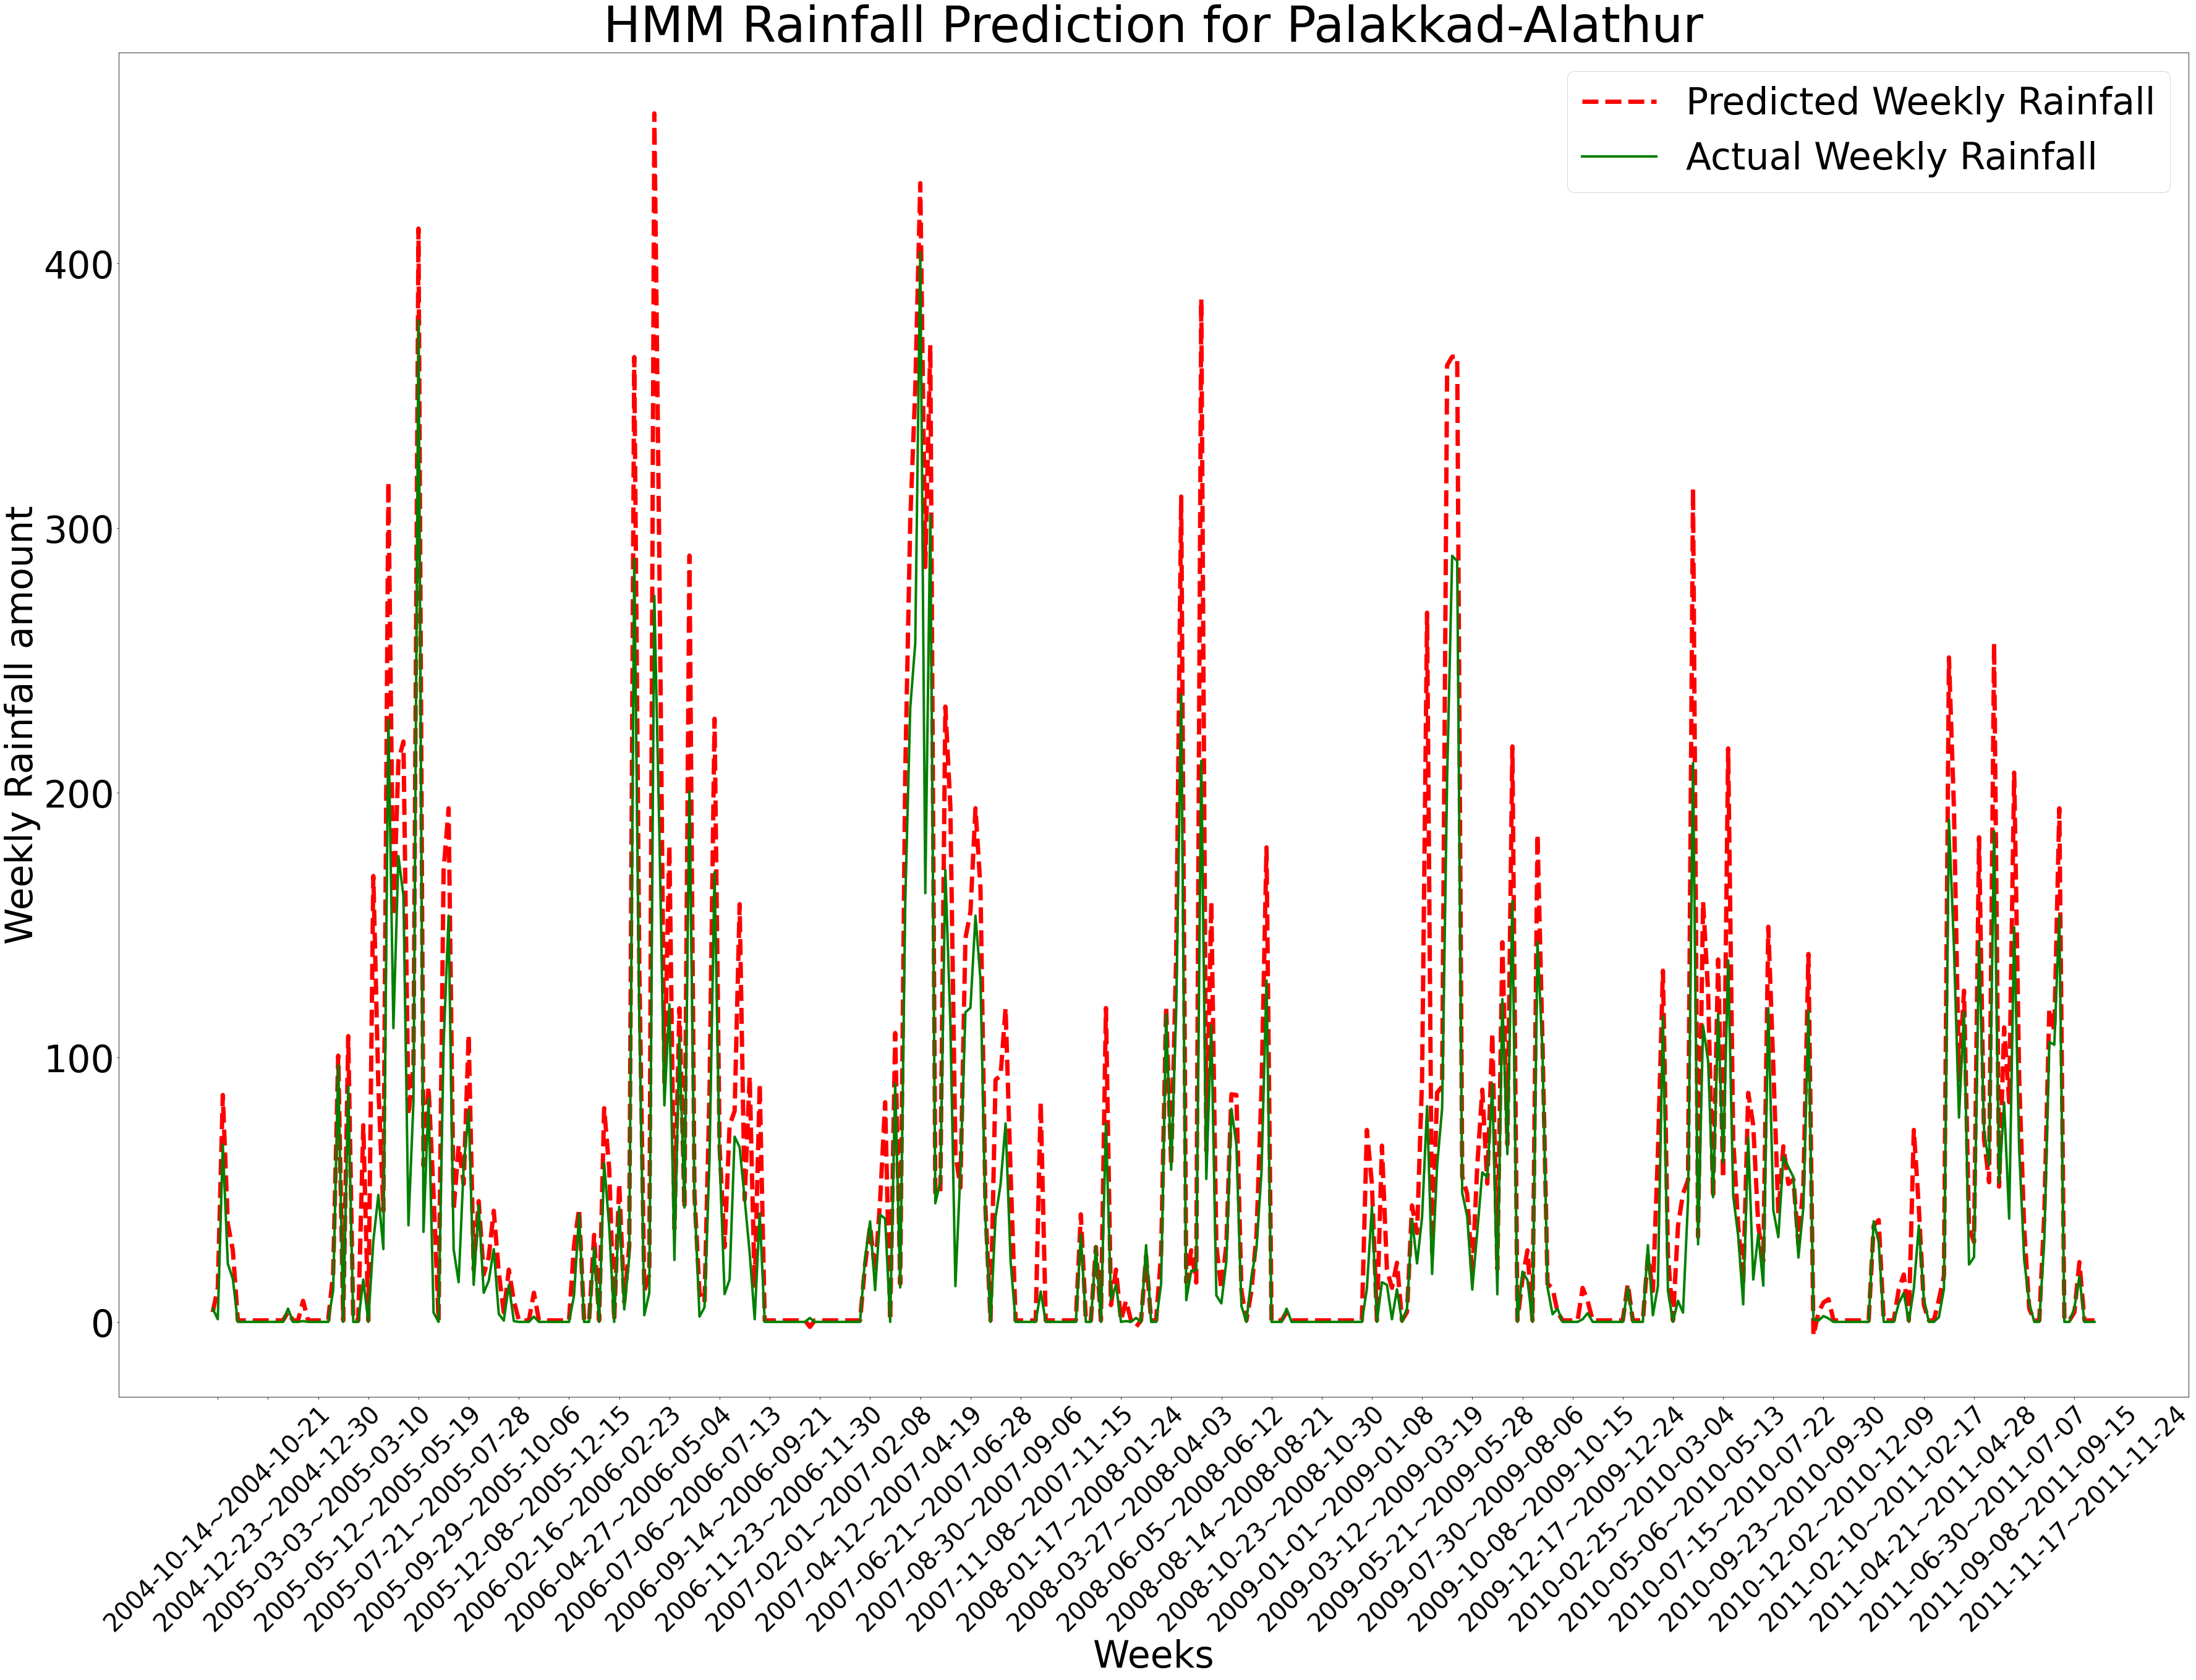

In [35]:
f = plt.figure() 
f.set_figwidth(60) 
f.set_figheight(40)
#plt.tick_params(axis='both', which='major', labelsize=30)
plt.title('HMM Rainfall Prediction for Palakkad-Alathur', fontsize = 80)
plt.xticks(fontsize=40, rotation=45)
plt.yticks(fontsize=60, rotation=0)
plt.xticks(ticks,xaxis)
plt.ylabel('Weekly Rainfall amount',fontsize=60)
plt.xlabel('Weeks',fontsize=60)
plt.plot(p2-7, 'r', linestyle='--', linewidth='7', label = 'Predicted Weekly Rainfall')
plt.plot(T1, 'g',linestyle='-', linewidth='4', label = 'Actual Weekly Rainfall')
plt.legend(loc='best',prop={'size': 60})

In [42]:
mean_squared_error(T1, p2-7, squared=False)

33.01305809642651

In [43]:
mae(T1,p2-7)

16.679421122752245

In [44]:
d1 = np.array(T1)
d1 = np.reshape(d1 , d1.shape[0])
d2 = np.array(p2)
d2 = np.reshape(d2 , d2.shape[0])

corr, _ = pearsonr(d1, d2)
corr

0.9677820121112534